In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']

### 合併資料

In [2]:
df1 = pd.read_excel("data/動平衡AI分析馬達資料彙整20230528.xlsx", sheet_name = "動平衡記錄資料", header = [0, 1])
df2 = pd.read_excel("data/動平衡AI分析馬達資料彙整20230528.xlsx", sheet_name = "成檢震動記錄資料", header = [0, 1])

In [3]:
df1_column = []
for col in df1.columns:
    if "Unnamed" in col[0]:
        df1_column.append(col[1])
    else:
        df1_column.append(f"{col[0]}_{col[1]}")
df1.columns = df1_column

df2_column = []
for col in df2.columns:
    if "Unnamed" in col[0]:
        df2_column.append(col[1])
    else:
        df2_column.append(f"{col[0]}_{col[1]}")
df2.columns = df2_column

In [4]:
df1 = df1[~df1.isnull().all(axis= 1)]
df2 = df2[~df2.isnull().all(axis= 1)]
df1.shape, df2.shape

((129, 17), (126, 16))

In [5]:
df = pd.merge(df1, df2, on = ["工號", "序號"], how = "outer")
df.shape

(129, 31)

In [6]:
df_col = []
for col in df.columns:
    col = col.replace("不平衡值", "").replace("成檢震動值L側(位移/速度)_", "").replace("成檢震動值F側(位移/速度)_", "").replace("(g)", "")
    df_col.append(col)
df.columns = df_col
df.head(3)

工號   序號  平衡轉速rpm  初始_L側角度  初始_L側不平衡量  初始_F側角度  初始_F側不平衡量  最終_L側角度   
0  FC223603T1  1.0    800.0    117.0       77.3    114.0      100.0    294.0  \
1  FC223603T1  2.0    800.0    264.0       51.5    132.0       87.0    184.0   
2  FC223603T1  3.0    800.0    269.0       82.2    263.0       87.1    301.0   

   最終_L側不平衡量  最終_F側角度  ...  LA位移 LA速度  FV位移  FV速度  FH位移  FH速度 FA位移  FA速度   
0       3.40     85.0  ...   4.0  0.4   6.0   1.4   7.0   1.7  6.0   1.5  \
1       2.37     34.0  ...   6.0  1.2   5.0   1.2   5.0   1.7  6.0   1.3   
2       4.10    306.0  ...   3.0  0.9   4.0   1.1   3.0   1.2  3.0   1.1   

   成檢平台編號_C  成檢方式(A平板/B壓腳/膠C墊)_A  
0    C-LINE                    B  
1    C-LINE                    B  
2    C-LINE                    B  

[3 rows x 31 columns]

In [7]:
int_col = [
    '序號', '平衡轉速rpm', '初始_L側角度', '初始_F側角度', '最終_L側角度', '最終_F側角度', '支撐位軸徑_r1', '支撐到轉子側_a', '轉子積厚_b', '轉子側到支撐_c',
    'LV位移', 'LH位移', 'LA位移', 'FV位移', 'FH位移', 'FA位移',
    ]
df[int_col] = df[int_col].astype(int)
df['序號'] = df['序號'].astype(object)
df.head(3)

工號 序號  平衡轉速rpm  初始_L側角度  初始_L側不平衡量  初始_F側角度  初始_F側不平衡量  最終_L側角度   
0  FC223603T1  1      800      117       77.3      114      100.0      294  \
1  FC223603T1  2      800      264       51.5      132       87.0      184   
2  FC223603T1  3      800      269       82.2      263       87.1      301   

   最終_L側不平衡量  最終_F側角度  ...  LA位移 LA速度  FV位移  FV速度  FH位移  FH速度 FA位移  FA速度   
0       3.40       85  ...     4  0.4     6   1.4     7   1.7    6   1.5  \
1       2.37       34  ...     6  1.2     5   1.2     5   1.7    6   1.3   
2       4.10      306  ...     3  0.9     4   1.1     3   1.2    3   1.1   

   成檢平台編號_C  成檢方式(A平板/B壓腳/膠C墊)_A  
0    C-LINE                    B  
1    C-LINE                    B  
2    C-LINE                    B  

[3 rows x 31 columns]

In [8]:
df.to_excel("data/data.xlsx", index = False)

### 缺失值

In [9]:
nan_col = df.isnull().any(axis = 0)
nan_col.loc["工號":"序號"] = True
df.loc[df.isnull().any(axis = 1), nan_col]

工號 序號 最終_平衡機代號 轉子側到支撐_支撐位置(A軸承位/B內側)
30   FC22A622T1  1      NaN                     B
31   FC22A622T1  2      NaN                     B
81   FC233540T1  5   AKASH1                   NaN
111  FC221518T1  4      NaN                     B

### 異常值

In [10]:
drop_id = df.query("最終_F側角度 > 360").index
print(f"drop_id = {drop_id}")

drop_id = Index([19], dtype='int64')


In [11]:
df.loc[drop_id, :"最終_F側角度"]

工號 序號  平衡轉速rpm  初始_L側角度  初始_L側不平衡量  初始_F側角度  初始_F側不平衡量  最終_L側角度   
19  FC223612T1  5      800      170       81.0      276      213.7      145  \

    最終_L側不平衡量  最終_F側角度  
19       2.11     2632

In [12]:
df.loc[drop_id, "最終_F側角度"] = 263

### 統計描述

In [13]:
describe = df.describe().T.round(2)
describe.loc[:"轉子側到支撐_c", "mean":]

mean     std     min     25%      50%      75%     max
平衡轉速rpm    979.07  210.16  700.00  800.00   800.00  1200.00  1500.0
初始_L側角度    149.36  112.12    2.00   54.00   116.00   250.00   359.0
初始_L側不平衡量   87.34   61.01    0.73   43.00    80.60   125.00   240.0
初始_F側角度    173.19  115.85    0.00   70.00   159.00   278.00   358.0
初始_F側不平衡量   77.84   52.97    0.76   42.20    78.00   109.00   234.0
最終_L側角度    183.40  106.66    2.00   84.00   184.00   276.00   357.0
最終_L側不平衡量    1.85    2.28    0.06    0.79     1.54     1.94    18.3
最終_F側角度    159.50  105.18    0.00   67.00   139.00   244.00   355.0
最終_F側不平衡量    1.87    1.58    0.18    1.06     1.62     2.35    14.0
支撐位軸徑_r1   184.74   81.87  122.00  125.00   130.00   250.00   320.0
支撐到轉子側_a   269.07   52.91  135.00  240.00   250.00   310.00   360.0
轉子積厚_b     900.97  198.53  470.00  715.00   860.00  1060.00  1170.0
轉子側到支撐_c   756.88  547.60   82.00  220.00  1060.00  1270.00  1390.0

In [14]:
describe.loc["LV位移":"FA速度", "mean":]

mean   std  min  25%  50%  75%   max
LV位移  5.36  2.52  2.0  3.0  5.0  7.0  11.0
LV速度  1.12  0.49  0.3  0.8  1.0  1.5   2.4
LH位移  5.97  2.60  2.0  4.0  6.0  7.0  12.0
LH速度  1.49  1.03  0.2  0.9  1.4  2.0  11.0
LA位移  3.81  1.66  1.0  2.0  3.0  5.0   8.0
LA速度  0.72  0.35  0.2  0.5  0.6  0.9   1.8
FV位移  4.77  1.91  2.0  3.0  4.0  6.0  11.0
FV速度  1.04  0.46  0.2  0.7  1.0  1.3   2.4
FH位移  6.36  2.50  2.0  4.0  6.0  8.0  12.0
FH速度  1.56  0.58  0.3  1.2  1.6  2.0   2.4
FA位移  4.29  1.76  1.0  3.0  4.0  5.0   9.0
FA速度  0.89  0.41  0.2  0.6  0.8  1.1   2.0

### 分類特徵

In [15]:
id_ = ['工號', '序號']
category = ['最終_平衡機代號', '轉子側到支撐_支撐位置(A軸承位/B內側)', '成檢平台編號_C', '成檢方式(A平板/B壓腳/膠C墊)_A']
displacement = []
speed = []
angle = []
balance = []
other = []
for col in df.columns:
    if "位移" in col:
        displacement.append(col)
    elif "速度" in col:
        speed.append(col)
    elif "不平衡量" in col:
        balance.append(col)
    elif "角度" in col:
        angle.append(col)
    elif (col not in id_) and (col not in category):
        other.append(col)
vibration = displacement + speed

### heatmap

In [16]:
df_num = df.select_dtypes("number")
corr = df_num.corr().round(2)
corr = corr.loc[:"轉子側到支撐_c", vibration]

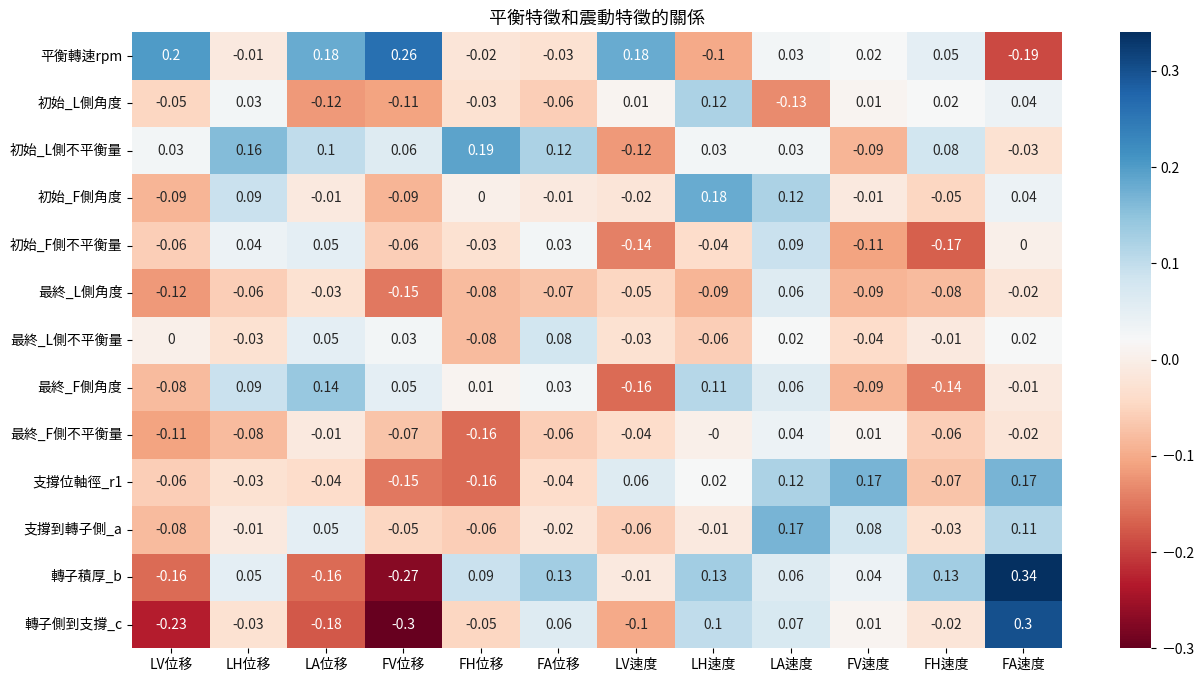

In [17]:
plt.figure(figsize=(15, 8))
sns.heatmap(data = corr, annot=True, cmap = 'RdBu')#, annot_kws={"fontsize": 9})
# plt.xticks(rotation = 30)
title = '平衡特徵和震動特徵的關係'
plt.title(title, fontsize = 13)
plt.show()

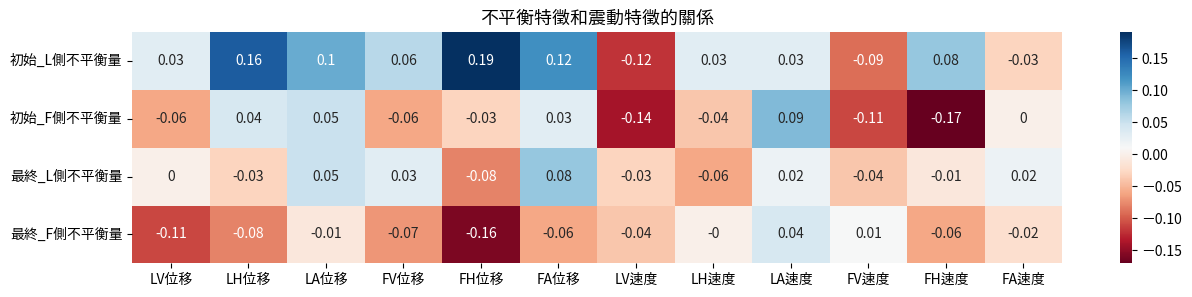

In [18]:
corr1 = corr.loc[balance, vibration]
plt.figure(figsize=(15, 3))
sns.heatmap(data = corr1, annot=True, cmap = 'RdBu')
plt.yticks(rotation = 360)
title = '不平衡特徵和震動特徵的關係'
plt.title(title, fontsize = 13)
plt.show()

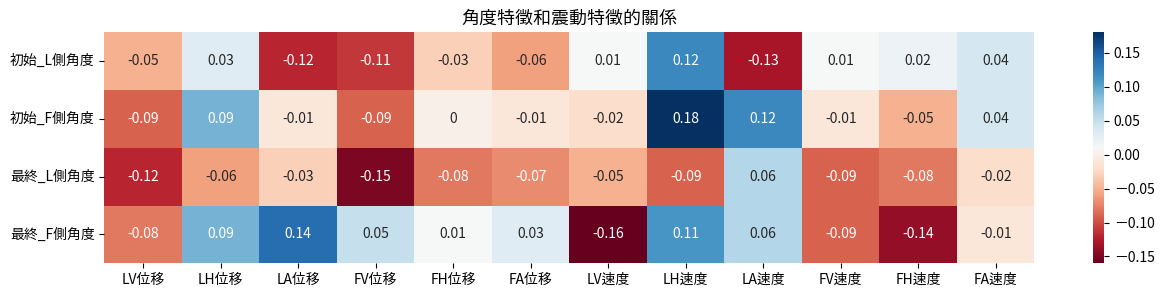

In [19]:
corr1 = corr.loc[angle, vibration]
plt.figure(figsize=(15, 3))
sns.heatmap(data = corr1, annot=True, cmap = 'RdBu')
plt.yticks(rotation = 360)
title = '角度特徵和震動特徵的關係'
plt.title(title, fontsize = 13)
plt.show()

In [20]:
corr = df_num.corr().round(2)
corr = corr.loc[displacement, speed]

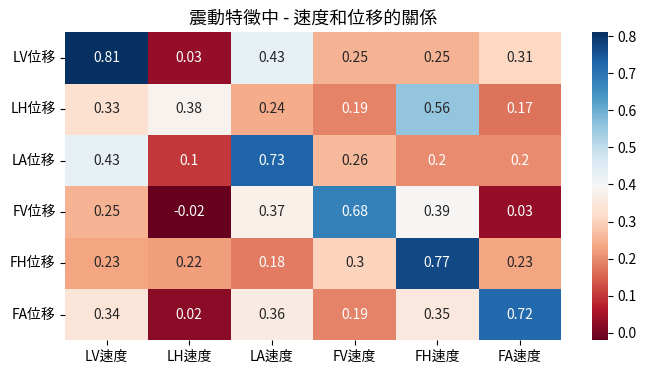

In [21]:
plt.figure(figsize=(8, 4))
sns.heatmap(data = corr, annot=True, cmap = 'RdBu')#, annot_kws={"fontsize": 9})
# plt.xticks(rotation = 30)
plt.yticks(rotation=360)
title = '震動特徵中 - 速度和位移的關係'
plt.title(title, fontsize = 13)
plt.show()

In [22]:
df_cycle = df_num.copy()
for col in angle:
    df_cycle[f"{col}_sin"] = np.sin(2 * np.pi * df_cycle[col] / 360)
    df_cycle[f"{col}_cos"] = np.cos(2 * np.pi * df_cycle[col] / 360)

In [23]:
corr = df_cycle.corr().round(2)
corr = corr.loc["初始_L側角度_sin":"最終_F側角度_cos", vibration]

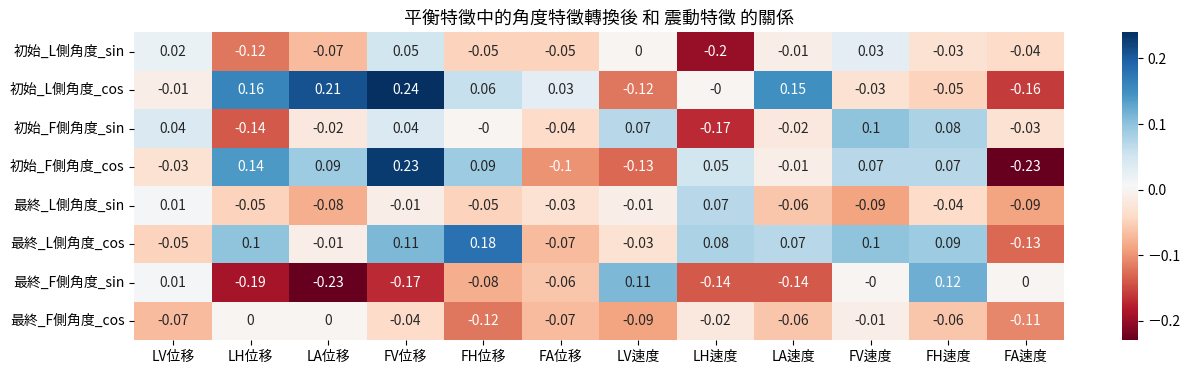

In [24]:
plt.figure(figsize=(15, 4))
sns.heatmap(data = corr, annot=True, cmap = 'RdBu')
title = '平衡特徵中的角度特徵轉換後 和 震動特徵 的關係'
plt.title(title, fontsize = 13)
plt.show()

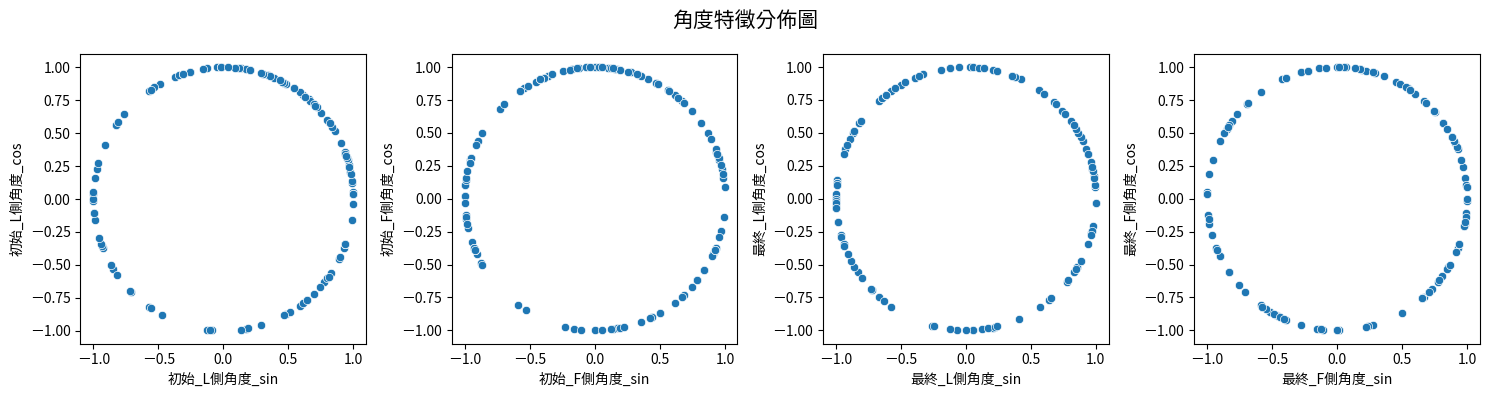

In [25]:
df_cycle1 = df_cycle.iloc[:, -8:]
cycle_col = df_cycle1.columns
a, b = 1, 4
fig, ax = plt.subplots(a, b, figsize = (15, 4))
for i in range(a):
    for j in range(b):
        sns.scatterplot(data = df_cycle1, x = cycle_col[j*2], y = cycle_col[j*2+1], ax = ax[j])
        # ax[i, j].set(xlabel = None, ylabel = None, title = cat_col[j])

title = '角度特徵分佈圖'
plt.suptitle(title, fontsize = 15)

plt.tight_layout()

### balance 與 vibration 未達標資料

In [26]:
df_eval = df[id_ + balance + vibration].copy()
df_eval["start_L_flag"] = df_eval.eval("初始_L側不平衡量 > 6").astype(int)
df_eval["start_F_flag"] = df_eval.eval("初始_F側不平衡量 > 6").astype(int)
df_eval["end_L_flag"] = df_eval.eval("最終_L側不平衡量 > 6").astype(int)
df_eval["end_F_flag"] = df_eval.eval("最終_F側不平衡量 > 6").astype(int)
df_eval["LV_flag"] = df_eval.eval("LV速度 > 2.5").astype(int)
df_eval["LH_flag"] = df_eval.eval("LH速度 > 2.5").astype(int)
df_eval["LA_flag"] = df_eval.eval("LA速度 > 2.5").astype(int)
df_eval["FV_flag"] = df_eval.eval("FV速度 > 2.5").astype(int)
df_eval["FH_flag"] = df_eval.eval("FH速度 > 2.5").astype(int)
df_eval["FA_flag"] = df_eval.eval("FA速度 > 2.5").astype(int)
flag = ['LV_flag', 'LH_flag', 'LA_flag', 'FV_flag', 'FH_flag', 'FA_flag']

In [27]:
adnormal = df_eval.loc[:, "start_L_flag":"start_F_flag"].any(axis = 1)
adnormal.value_counts()

True     115
False     14
Name: count, dtype: int64

In [28]:
adnormal = df_eval.loc[:, "end_L_flag":"end_F_flag"].any(axis = 1)
adnormal.value_counts()

False    126
True       3
Name: count, dtype: int64

In [29]:
df[adnormal].loc[:, :"最終_F側不平衡量"]

工號 序號  平衡轉速rpm  初始_L側角度  初始_L側不平衡量  初始_F側角度  初始_F側不平衡量  最終_L側角度   
101  FC234525T1  1     1500       36      141.0       21       97.3      194  \
102  FC234525T1  2     1500       45      198.0        8       96.0      187   
103  FC234525T1  3     1500       55      102.0       19       58.5      121   

     最終_L側不平衡量  最終_F側角度  最終_F側不平衡量  
101       18.3      344       6.90  
102       14.4      296       5.31  
103       12.9      272      14.00

In [30]:
df[adnormal][id_ + vibration]

工號 序號  LV位移  LH位移  LA位移  FV位移  FH位移  FA位移  LV速度  LH速度  LA速度   
101  FC234525T1  1     7     6     5     6     6     5   0.9   0.6   0.5  \
102  FC234525T1  2     5     4     4     5     4     5   0.5   0.5   0.5   
103  FC234525T1  3     7     7     6     7     6     5   1.5   1.6   1.2   

     FV速度  FH速度  FA速度  
101   0.6   1.4   0.7  
102   0.5   1.1   0.5  
103   1.4   1.8   0.7

In [31]:
adnormal = df_eval.loc[:, flag].any(axis = 1)
adnormal.value_counts()

False    128
True       1
Name: count, dtype: int64

In [32]:
df[adnormal].loc[:, :"最終_F側不平衡量"]

工號 序號  平衡轉速rpm  初始_L側角度  初始_L側不平衡量  初始_F側角度  初始_F側不平衡量  最終_L側角度   
107  FC222501T1  4      800      273       83.7      300       43.7       60  \

     最終_L側不平衡量  最終_F側角度  最終_F側不平衡量  
107       1.72      287       2.11

In [33]:
df[adnormal][id_ + vibration]

工號 序號  LV位移  LH位移  LA位移  FV位移  FH位移  FA位移  LV速度  LH速度  LA速度   
107  FC222501T1  4     2     5     3     2     4     2   0.7  11.0   0.6  \

     FV速度  FH速度  FA速度  
107   0.6   0.7   0.4

### balance 與 vibration 分布

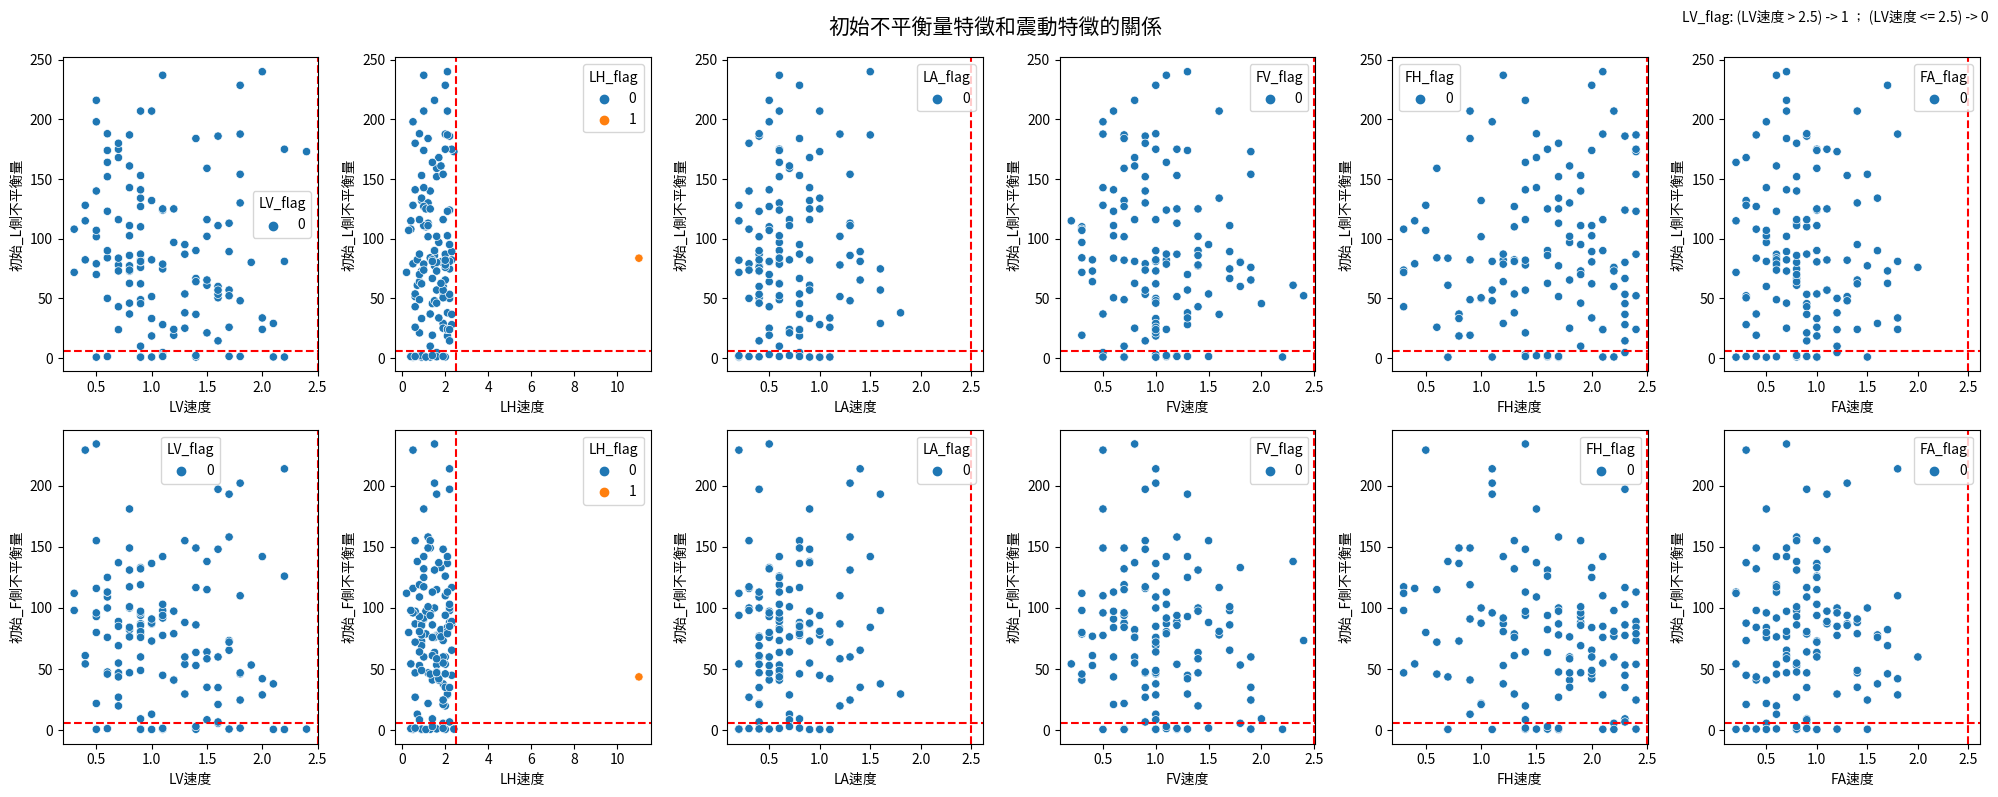

In [34]:
hue = flag
x_col = speed
y_col = balance[:2]
a, b = 2, 6
fig, ax = plt.subplots(a, b, figsize = (20, 8))
for i in range(a):
    for j in range(b):
        sns.scatterplot(data = df_eval, x = x_col[j], y = y_col[i], hue = hue[j], ax = ax[i, j])
        ax[i, j].axhline(y=6, color='red', linestyle='--')
        ax[i, j].axvline(x=2.5, color='red', linestyle='--')
        # ax[i, j].set(xlabel = None, ylabel = None, title = cat_col[j])

title = '初始不平衡量特徵和震動特徵的關係'
plt.suptitle(title, fontsize = 15)

plt.tight_layout()

subtitle = "LV_flag: (LV速度 > 2.5) -> 1 ； (LV速度 <= 2.5) -> 0"
plt.text(0.92, 0.975, subtitle, ha='center', fontsize=10, transform=fig.transFigure)
plt.show()

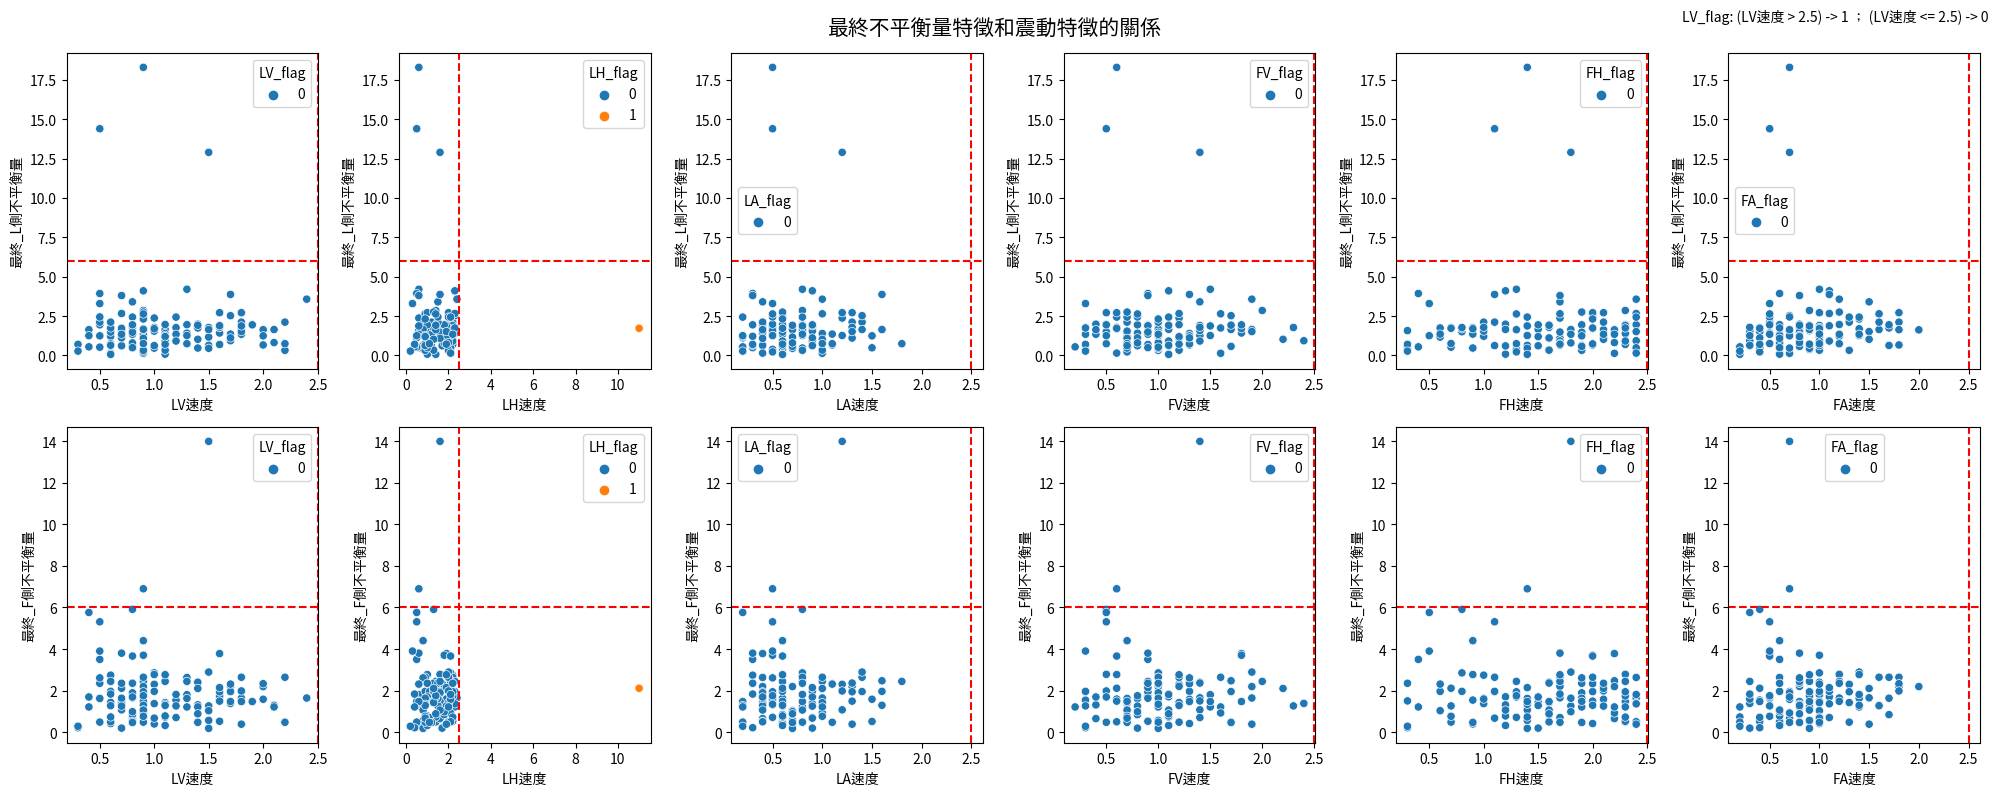

In [35]:
hue = flag
x_col = speed
y_col = balance[2:]
a, b = 2, 6
fig, ax = plt.subplots(a, b, figsize = (20, 8))
for i in range(a):
    for j in range(b):
        sns.scatterplot(data = df_eval, x = x_col[j], y = y_col[i], hue = hue[j], ax = ax[i, j])
        ax[i, j].axhline(y=6, color='red', linestyle='--')
        ax[i, j].axvline(x=2.5, color='red', linestyle='--')
        # ax[i, j].set(xlabel = None, ylabel = None, title = cat_col[j])

title = '最終不平衡量特徵和震動特徵的關係'
plt.suptitle(title, fontsize = 15)

plt.tight_layout()

subtitle = "LV_flag: (LV速度 > 2.5) -> 1 ； (LV速度 <= 2.5) -> 0"
plt.text(0.92, 0.975, subtitle, ha='center', fontsize=10, transform=fig.transFigure)
plt.show()

### 角度離散化

In [36]:
df_angle = df.copy()
angle_bin = []
for col in angle:
    df_angle[f"{col}_bin"] = pd.cut(df_angle[col], [0, 90, 180, 270, 360], labels = [90, 180, 270, 360])
    angle_bin.append(f"{col}_bin")

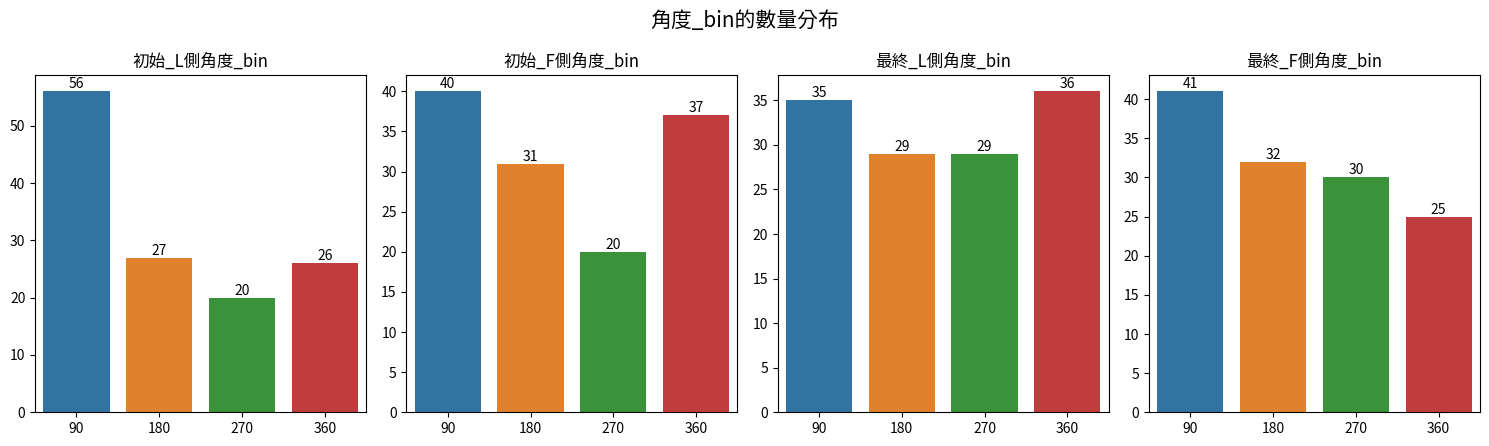

In [37]:
cat_col = ["Survived", "Pclass", "Sex", "Embarked"]
a, b = 1, 4
fig, ax = plt.subplots(a, b, figsize = (15, 4.5))
for i in range(a):
    for j in range(b):
        sns.countplot(data = df_angle, x = angle_bin[j], ax = ax[j])
        ax[j].set(xlabel = None, ylabel = None, title = angle_bin[j])

        for p in ax[j].patches:
            ax[j].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

title = '角度_bin的數量分布'
plt.suptitle(title, fontsize = 15)

plt.tight_layout()

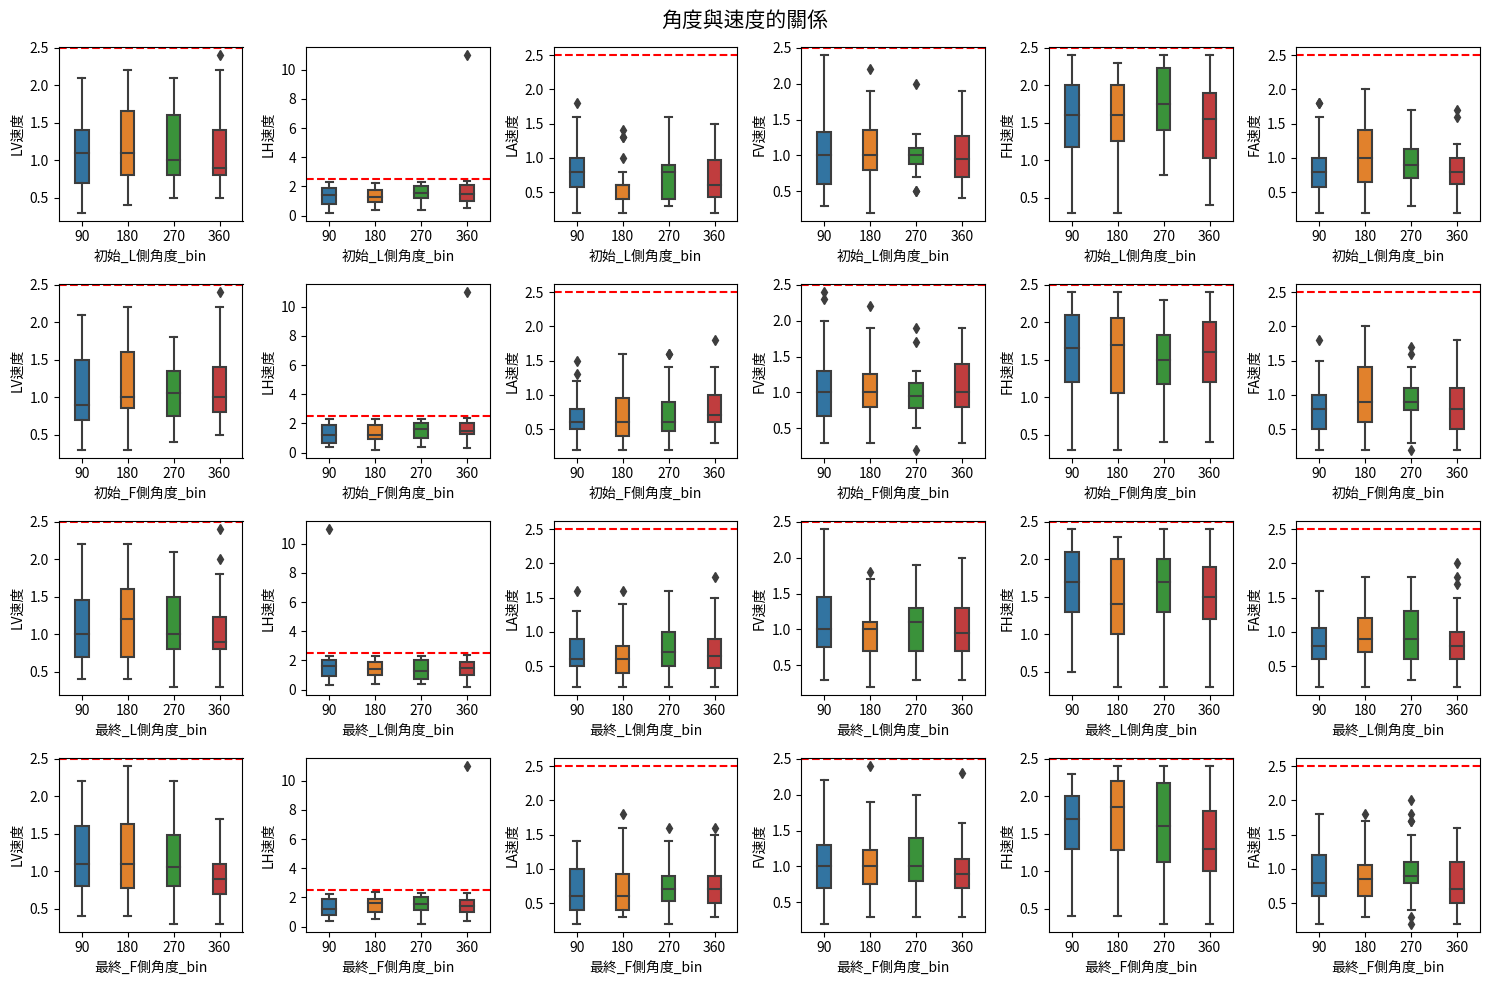

In [38]:
a, b = 4, 6
fig, ax = plt.subplots(a, b, figsize = (15, 10))
for i in range(a):
    for j in range(b):
        sns.boxplot(x = angle_bin[i], y = speed[j], data = df_angle, width = 0.3, ax = ax[i, j])
        ax[i, j].axhline(y=2.5, color='red', linestyle='--')
        # ax[i, j].set(xlabel = None, ylabel = None, title = vibration[j])

title = '角度與速度的關係'
plt.suptitle(title, fontsize = 15)
plt.tight_layout()

### 類別與目標值的關係

In [39]:
df_eval1 = df_eval[id_].copy()
df_eval1["start_balance"] = df_eval[["start_L_flag", "start_F_flag"]].any(axis = 1).astype(int)
df_eval1["end_balance"] = df_eval[["end_L_flag", "end_F_flag"]].any(axis = 1).astype(int)
df_eval1["vibration"] = df_eval[flag].any(axis = 1).astype(int)
df_eval1.head(3)

工號 序號  start_balance  end_balance  vibration
0  FC223603T1  1              1            0          0
1  FC223603T1  2              1            0          0
2  FC223603T1  3              1            0          0

In [40]:
df["最終_平衡機代號"].value_counts()

最終_平衡機代號
Hotmann    46
HR-6       34
AKASH1     17
HM7V       11
H6V         7
HOTMANN     6
HMTV        2
AKASHI      2
H6-V        1
Name: count, dtype: int64

In [41]:
# "H6-V"輸入錯誤
df["最終_平衡機代號"] = df["最終_平衡機代號"].replace("H6-V", "H6V")
df["最終_平衡機代號"].value_counts()

最終_平衡機代號
Hotmann    46
HR-6       34
AKASH1     17
HM7V       11
H6V         8
HOTMANN     6
HMTV        2
AKASHI      2
Name: count, dtype: int64

In [42]:
df1 = pd.merge(df, df_eval1, on = id_)
df1.head(3)

工號 序號  平衡轉速rpm  初始_L側角度  初始_L側不平衡量  初始_F側角度  初始_F側不平衡量  最終_L側角度   
0  FC223603T1  1      800      117       77.3      114      100.0      294  \
1  FC223603T1  2      800      264       51.5      132       87.0      184   
2  FC223603T1  3      800      269       82.2      263       87.1      301   

   最終_L側不平衡量  最終_F側角度  ...  FV速度 FH位移  FH速度  FA位移  FA速度  成檢平台編號_C   
0       3.40       85  ...   1.4    7   1.7     6   1.5    C-LINE  \
1       2.37       34  ...   1.2    5   1.7     6   1.3    C-LINE   
2       4.10      306  ...   1.1    3   1.2     3   1.1    C-LINE   

  成檢方式(A平板/B壓腳/膠C墊)_A  start_balance  end_balance  vibration  
0                   B              1            0          0  
1                   B              1            0          0  
2                   B              1            0          0  

[3 rows x 34 columns]

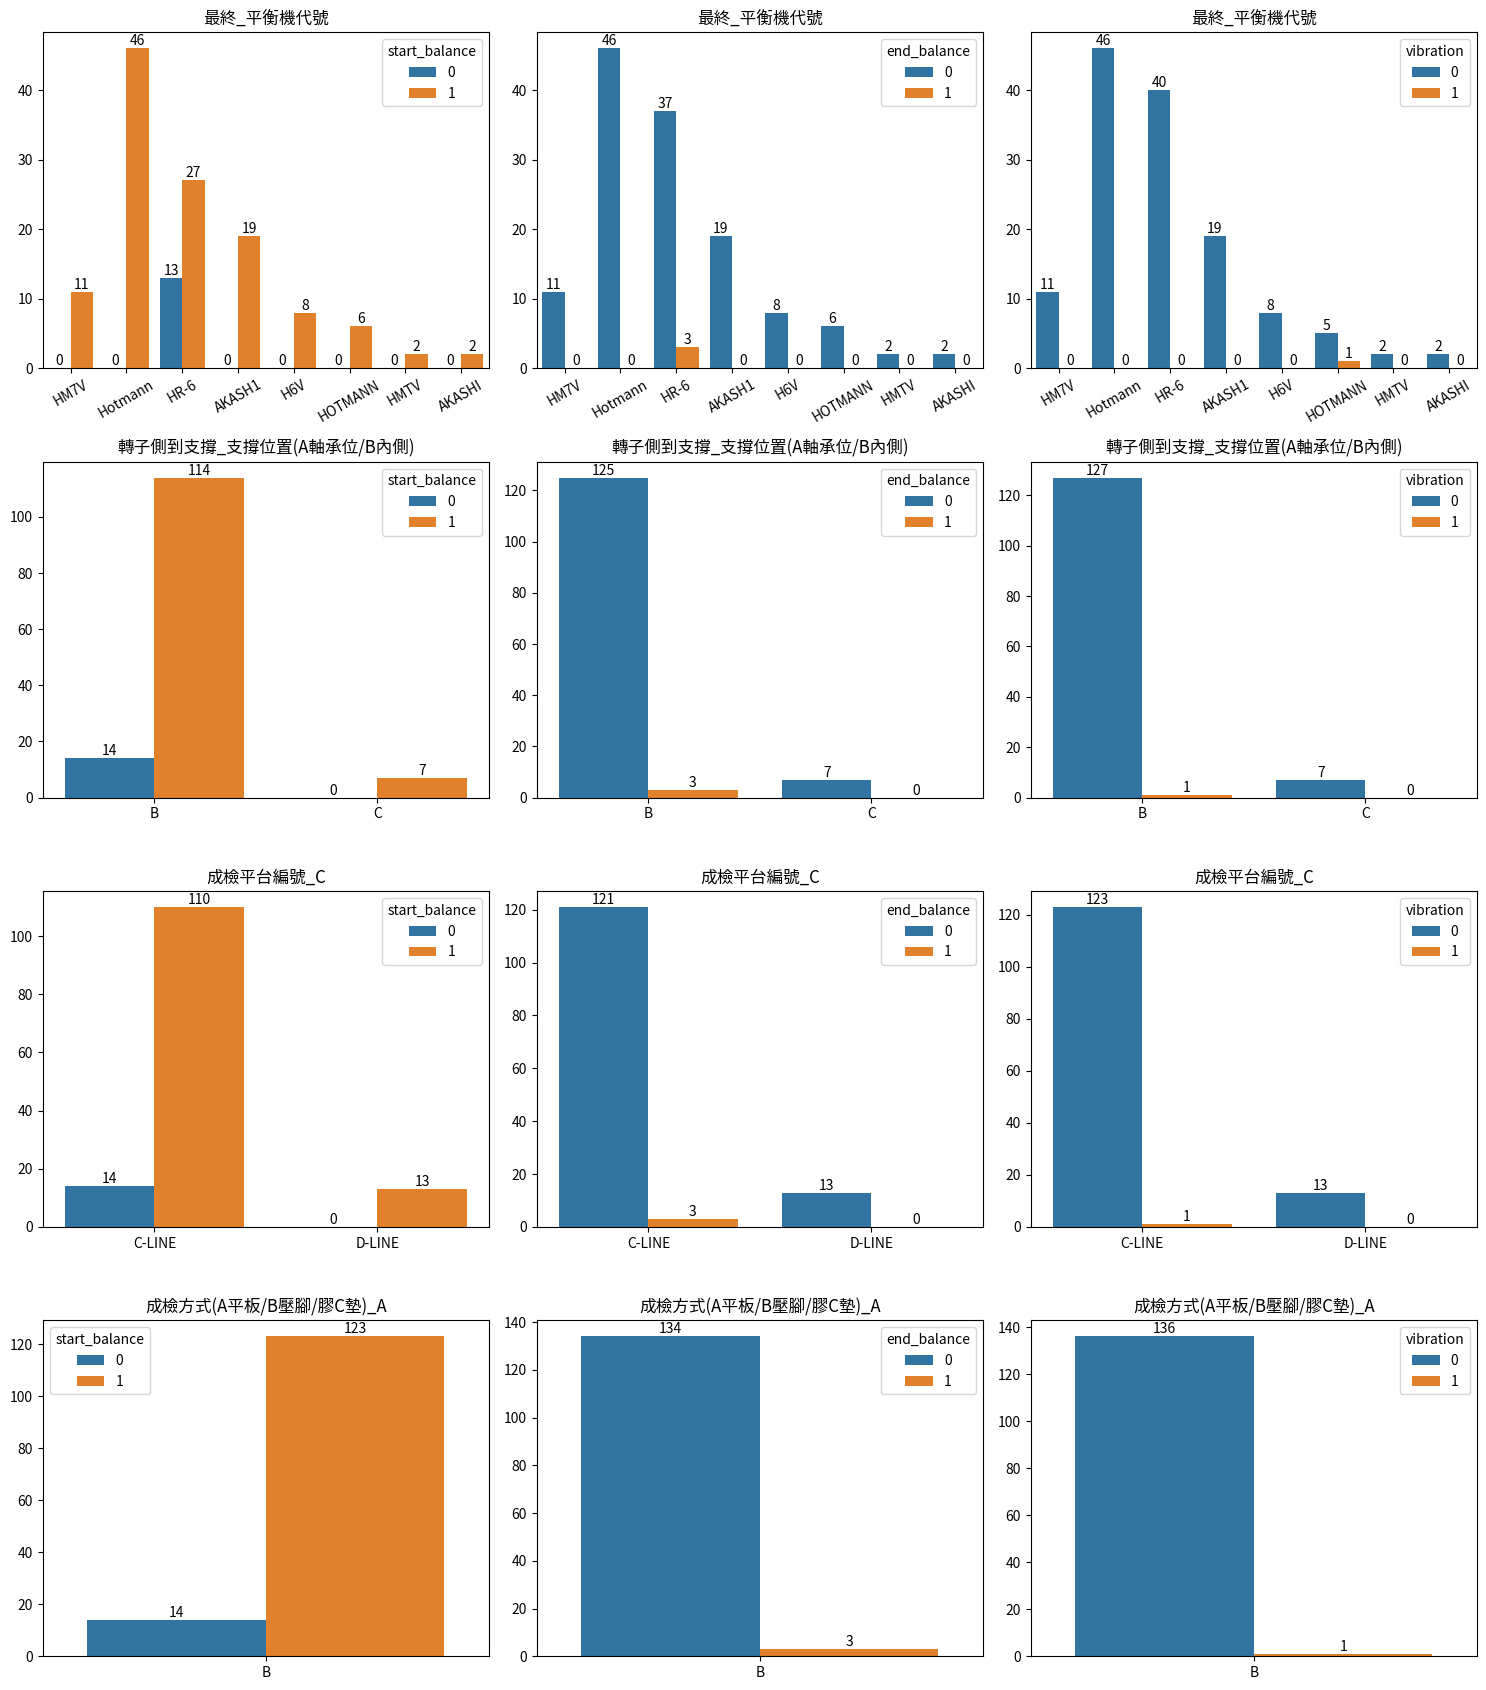

In [43]:
hue = ["start_balance", "end_balance", "vibration"]
a, b = 4, 3
fig, ax = plt.subplots(a, b, figsize = (15, 17))
for i in range(a):
    for j in range(b):
        sns.countplot(data = df1, x = category[i], hue = hue[j], ax = ax[i, j])
        ax[i, j].set(xlabel = None, ylabel = None, title = category[i])

        for p in ax[i, j].patches:
            ax[i, j].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
        
        if i == 0:
            ax[i, j].tick_params(axis = "x", rotation = 30)

plt.tight_layout()

### 以平衡機代號分割後的相關性

In [44]:
machine_g = df.groupby(category[0])
sizes = machine_g.size()
sizes = sizes[sizes > 10]

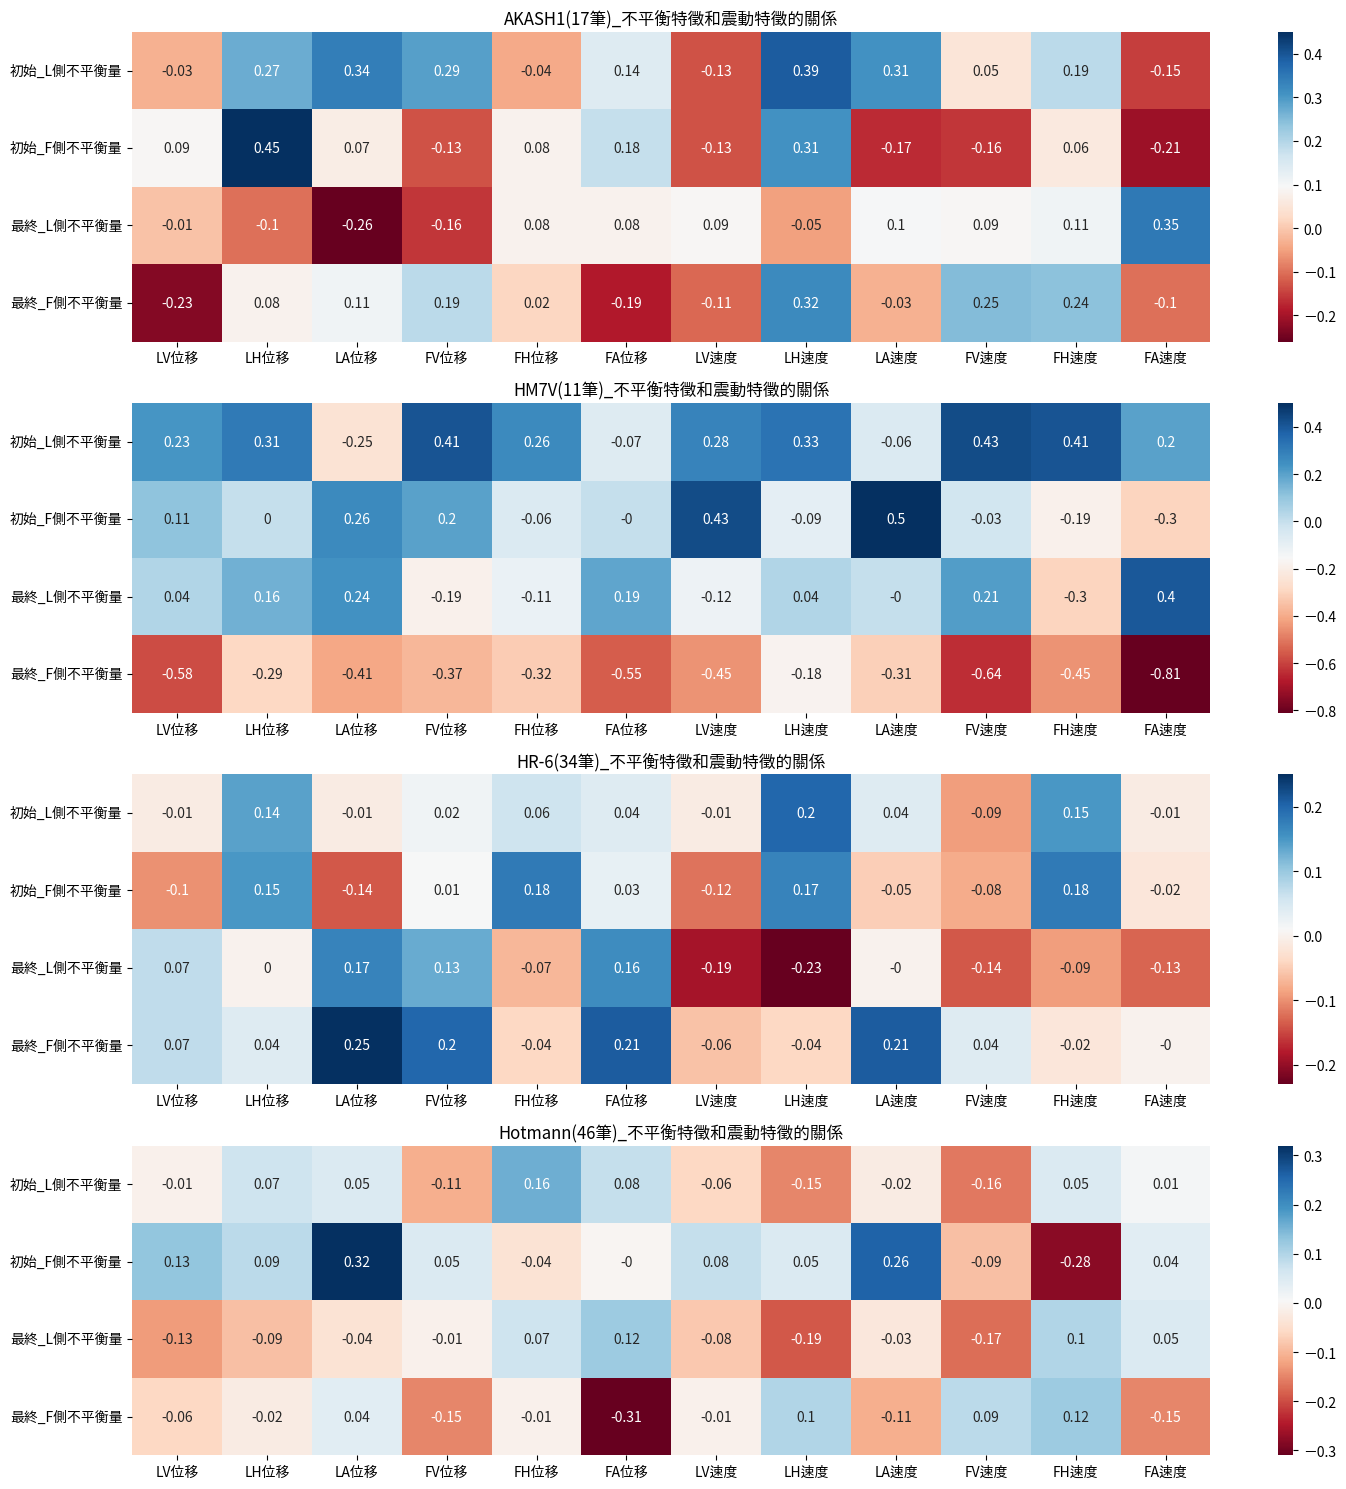

In [45]:
a, b = len(sizes), 1
fig, ax = plt.subplots(a, b, figsize = (15, 15))

for i, (group, num) in enumerate(sizes.to_dict().items()):
    sub_df = machine_g.get_group(group)
    sub_df_num = sub_df.select_dtypes("number")

    corr = sub_df_num.corr().round(2)
    corr1 = corr.loc[balance, vibration]

    sns.heatmap(data = corr1, annot=True, cmap = 'RdBu', ax = ax[i])
    ax[i].set(title = f"{group}({num}筆)_不平衡特徵和震動特徵的關係")

plt.tight_layout()
plt.show()

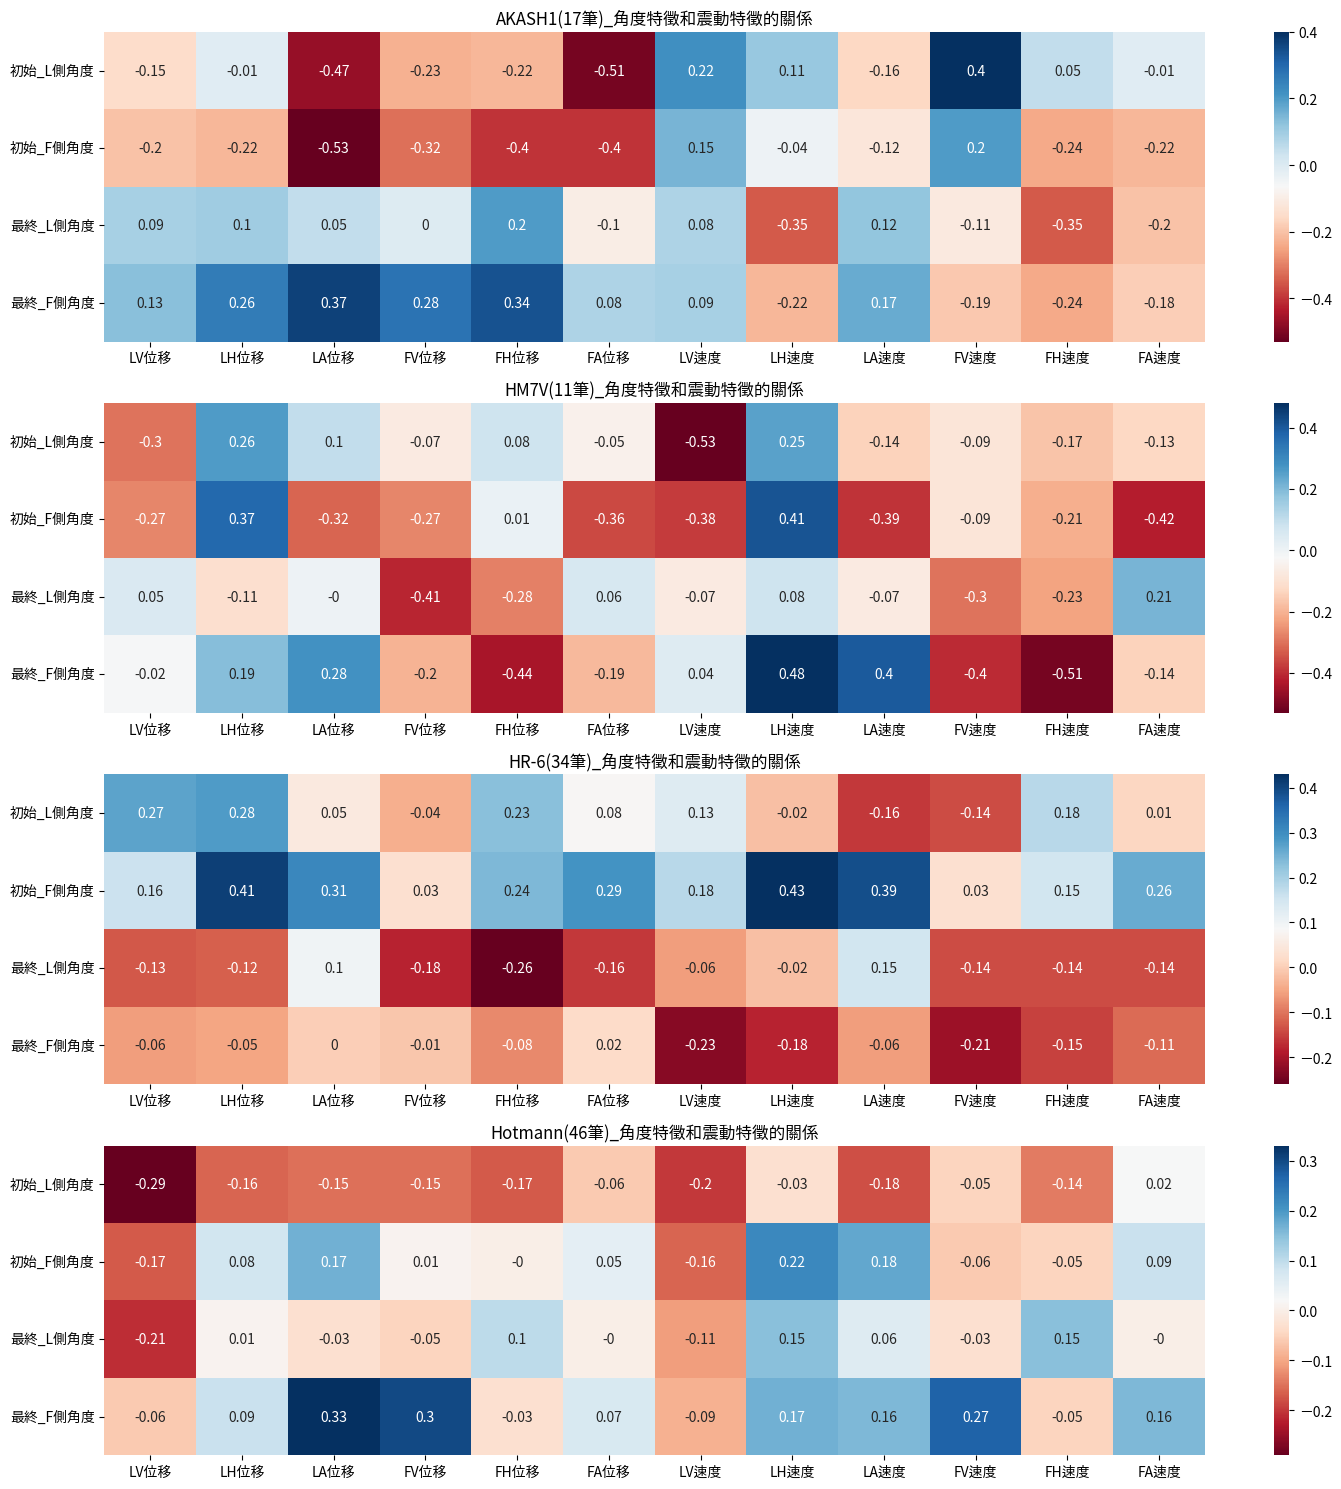

In [46]:
a, b = len(sizes), 1
fig, ax = plt.subplots(a, b, figsize = (15, 15))

for i, (group, num) in enumerate(sizes.to_dict().items()):
    sub_df = machine_g.get_group(group)
    sub_df_num = sub_df.select_dtypes("number")

    corr = sub_df_num.corr().round(2)
    corr1 = corr.loc[angle, vibration]

    sns.heatmap(data = corr1, annot=True, cmap = 'RdBu', ax = ax[i])
    ax[i].set(title = f"{group}({num}筆)_角度特徵和震動特徵的關係")

plt.tight_layout()
plt.show()

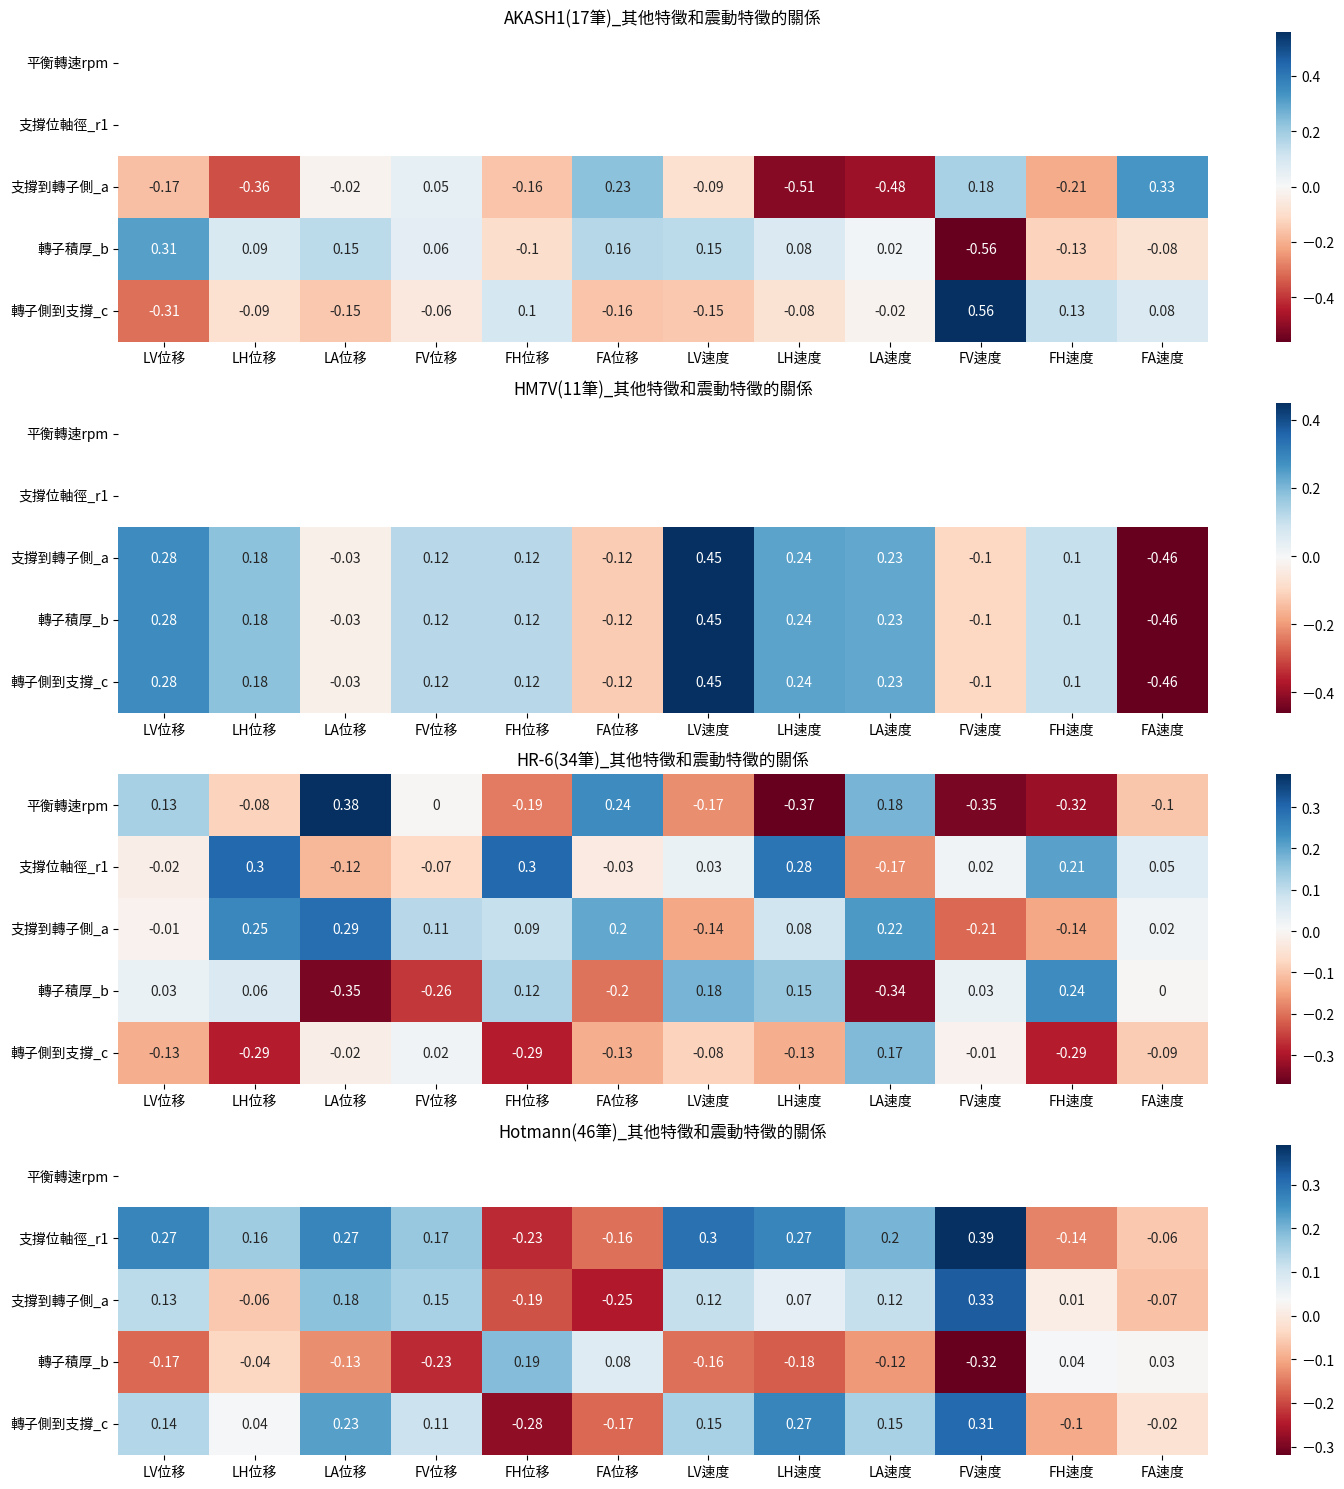

In [47]:
a, b = len(sizes), 1
fig, ax = plt.subplots(a, b, figsize = (15, 15))

for i, (group, num) in enumerate(sizes.to_dict().items()):
    sub_df = machine_g.get_group(group)
    sub_df_num = sub_df.select_dtypes("number")

    corr = sub_df_num.corr().round(2)
    corr1 = corr.loc[other, vibration]

    sns.heatmap(data = corr1, annot=True, cmap = 'RdBu', ax = ax[i])
    ax[i].set(title = f"{group}({num}筆)_其他特徵和震動特徵的關係")

plt.tight_layout()
plt.show()

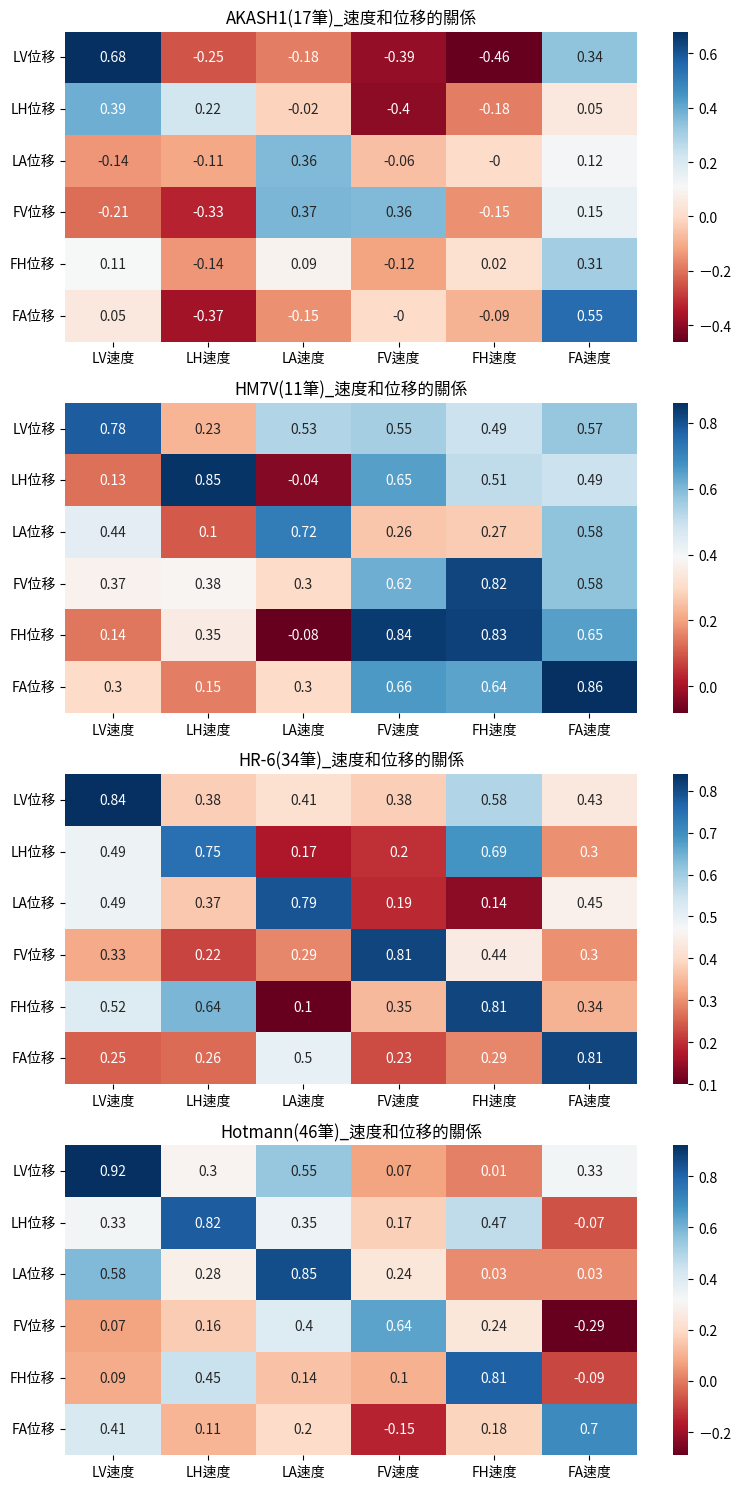

In [48]:
a, b = len(sizes), 1
fig, ax = plt.subplots(a, b, figsize = (8, 15))

for i, (group, num) in enumerate(sizes.to_dict().items()):
    sub_df = machine_g.get_group(group)
    sub_df_num = sub_df.select_dtypes("number")

    corr = sub_df_num.corr().round(2)
    corr1 = corr.loc[displacement, speed]

    sns.heatmap(data = corr1, annot=True, cmap = 'RdBu', ax = ax[i])
    ax[i].set(title = f"{group}({num}筆)_速度和位移的關係")

plt.tight_layout()
plt.show()

### 以平衡轉速分割後的相關性

In [49]:
rpm_g = df.groupby("平衡轉速rpm")
sizes = rpm_g.size()
sizes = sizes[sizes > 1]

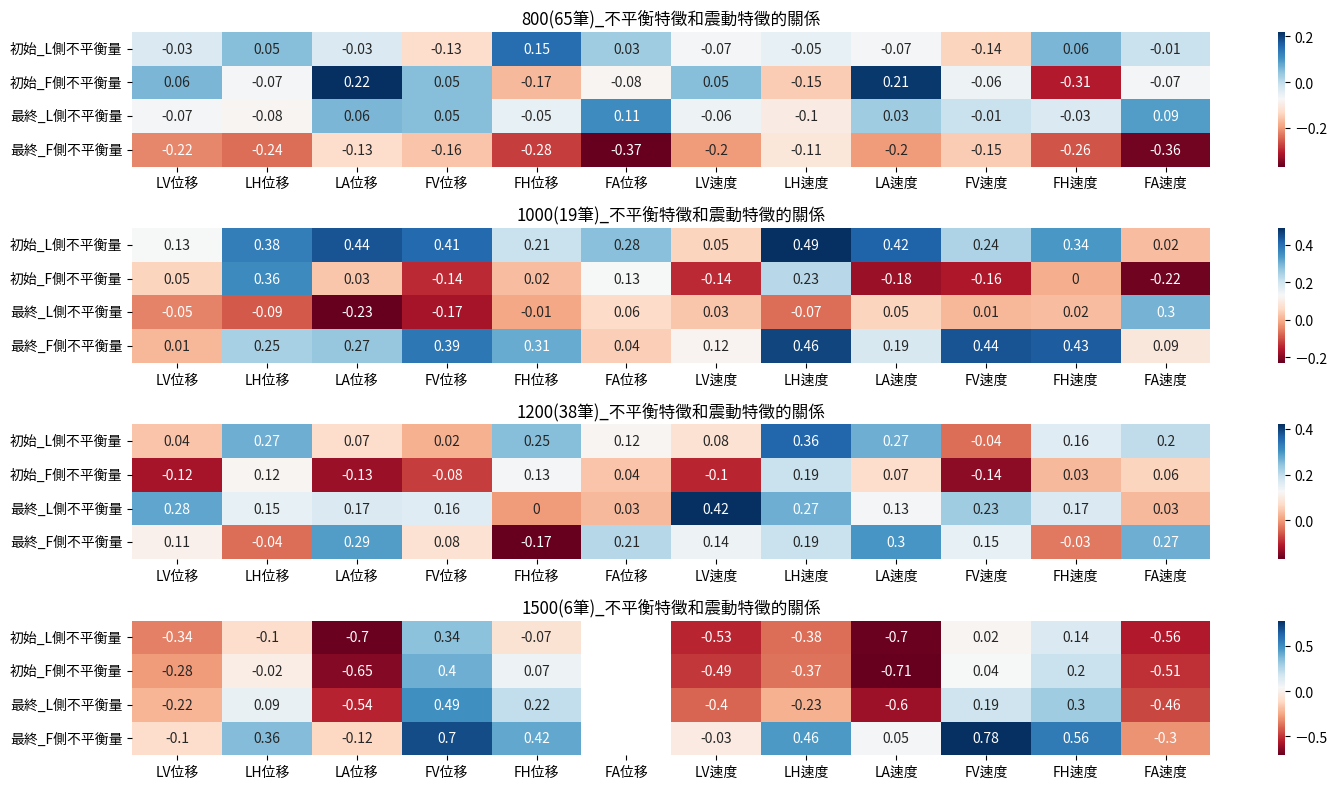

In [50]:
a, b = len(sizes), 1
fig, ax = plt.subplots(a, b, figsize = (15, 8))

for i, (group, num) in enumerate(sizes.to_dict().items()):
    sub_df = rpm_g.get_group(group)
    sub_df_num = sub_df.select_dtypes("number")

    corr = sub_df_num.corr().round(2)
    corr1 = corr.loc[balance, vibration]

    sns.heatmap(data = corr1, annot=True, cmap = 'RdBu', ax = ax[i])
    ax[i].set(title = f"{group}({num}筆)_不平衡特徵和震動特徵的關係")

plt.tight_layout()
plt.show()

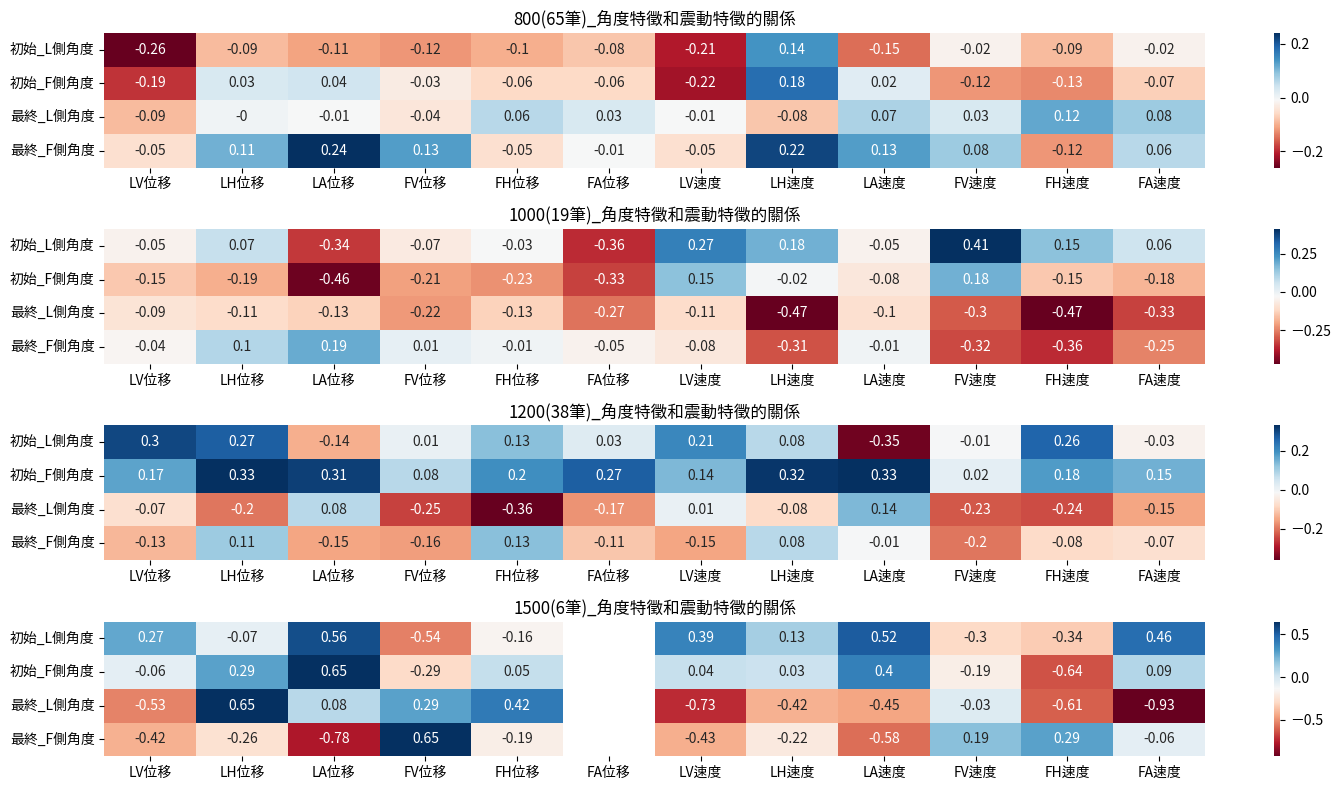

In [51]:
a, b = len(sizes), 1
fig, ax = plt.subplots(a, b, figsize = (15, 8))

for i, (group, num) in enumerate(sizes.to_dict().items()):
    sub_df = rpm_g.get_group(group)
    sub_df_num = sub_df.select_dtypes("number")

    corr = sub_df_num.corr().round(2)
    corr1 = corr.loc[angle, vibration]

    sns.heatmap(data = corr1, annot=True, cmap = 'RdBu', ax = ax[i])
    ax[i].set(title = f"{group}({num}筆)_角度特徵和震動特徵的關係")

plt.tight_layout()
plt.show()

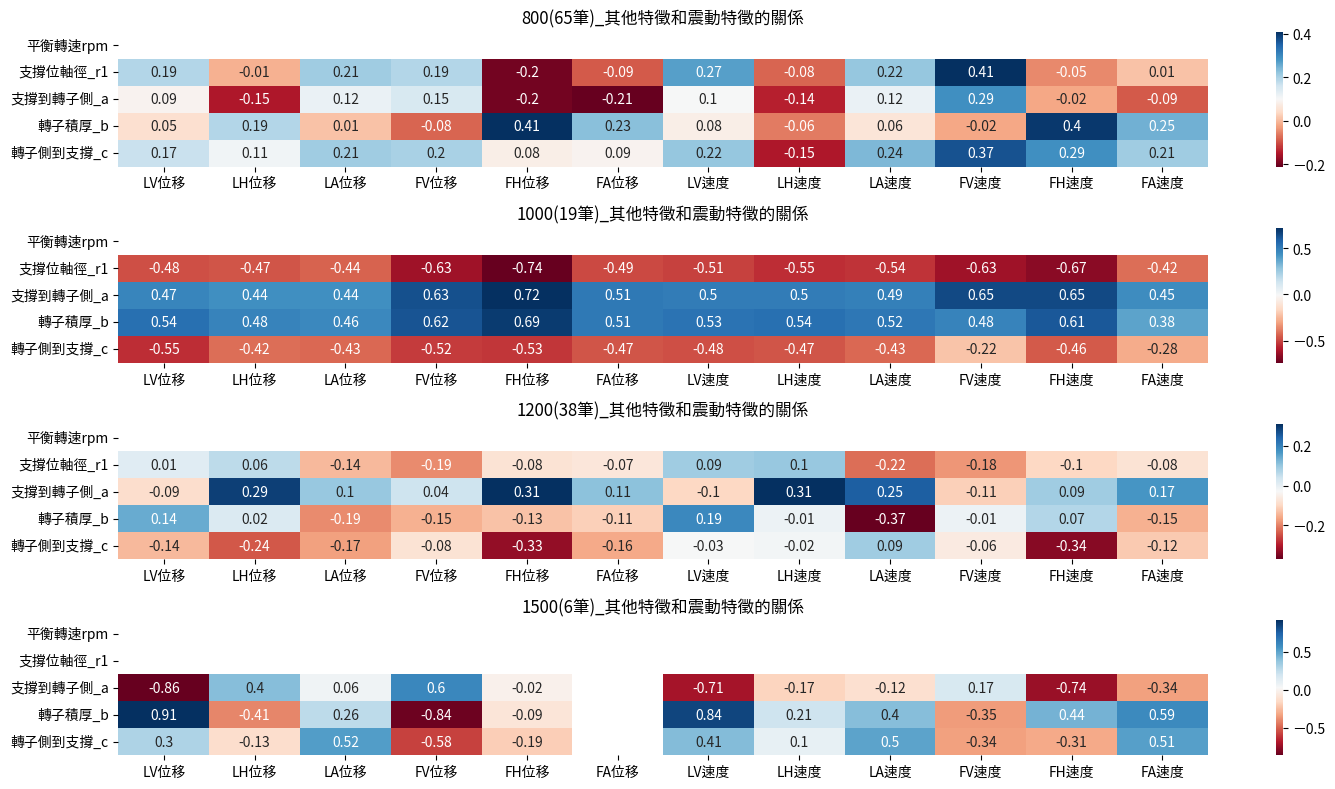

In [52]:
a, b = len(sizes), 1
fig, ax = plt.subplots(a, b, figsize = (15, 8))

for i, (group, num) in enumerate(sizes.to_dict().items()):
    sub_df = rpm_g.get_group(group)
    sub_df_num = sub_df.select_dtypes("number")

    corr = sub_df_num.corr().round(2)
    corr1 = corr.loc[other, vibration]

    sns.heatmap(data = corr1, annot=True, cmap = 'RdBu', ax = ax[i])
    ax[i].set(title = f"{group}({num}筆)_其他特徵和震動特徵的關係")

plt.tight_layout()
plt.show()

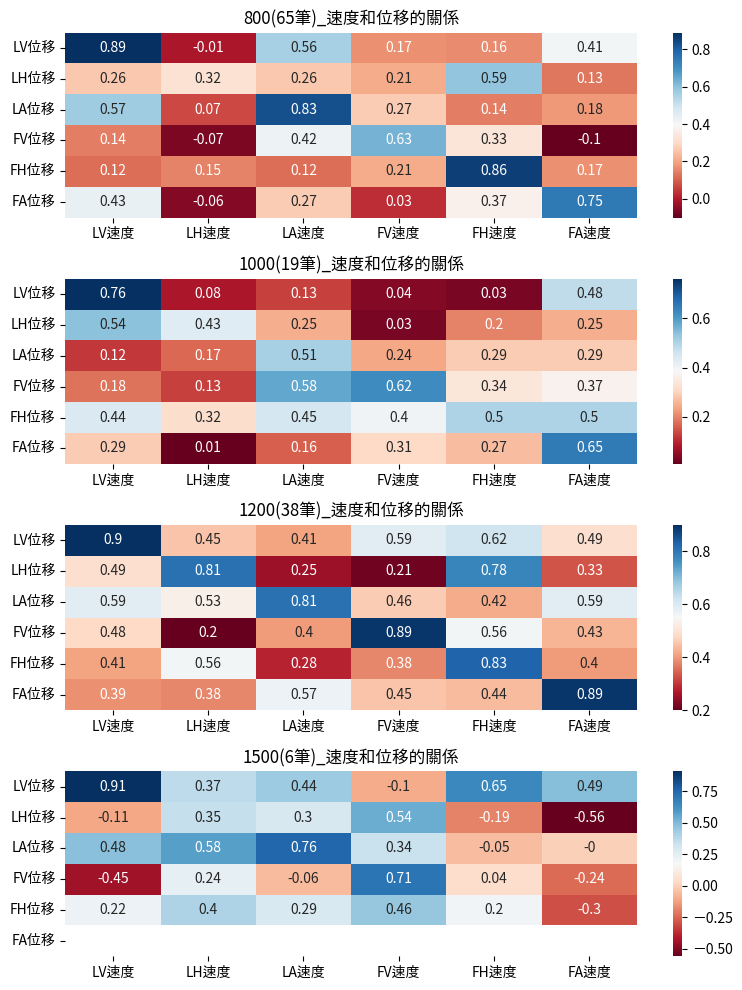

In [53]:
a, b = len(sizes), 1
fig, ax = plt.subplots(a, b, figsize = (8, 10))

for i, (group, num) in enumerate(sizes.to_dict().items()):
    sub_df = rpm_g.get_group(group)
    sub_df_num = sub_df.select_dtypes("number")

    corr = sub_df_num.corr().round(2)
    corr1 = corr.loc[displacement, speed]

    sns.heatmap(data = corr1, annot=True, cmap = 'RdBu', ax = ax[i])
    ax[i].set(title = f"{group}({num}筆)_速度和位移的關係")

plt.tight_layout()
plt.show()